## TRAINING
This notebook has as an objective to use a folder containing the formated .npy files to train a deep learning model that can be used in lieu of an FEA model to any accuracy above random, for a proof of concept that it is possible to do so, such that further research can be done afterward to optimize architecture, hyperparameters and data being fed in.

In [2]:
##  imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import PREPROCESSING_splitting as split
import matplotlib.pyplot as plt

splitting functions imported


In [1]:
## first, create a class to load the files that are to be fed to the neural network, 
## for both the inputs and the outputs. To avoid confusion I'll refer to the inputs to the 
## FEA model as 'bound_conds' (boundary conditions), and the outputs as 'targets', while what 
## is fed into the neural network will be called an "input", and the output of the neural network "prediction"
## this function should probably be transformed into a dataloader later for a larger dataset, 
## but for now we'll keep it like this

def get_dataset(dataset_path, glob_parameter = '*.npy'):
    # concatenates all samples into a list of boundary conditions and a list of targets
    
    # set paths
    bound_cond_path = pathlib.Path(dataset_path, 'input')
    targets_path = pathlib.Path(dataset_path, 'output')

    test = pathlib.Path('D:/')
    
    
    
    
    # check if folder path is correct
    if bound_cond_path.is_dir() and targets_path.is_dir():
        print('path contains \'input\' and \'output\'')
        pass
    else:
        raise Exception (f'Argument dataset_path: {dataset_path} should contain folders ..\input and ..\output. Please check path')
    
    #create iterators for files
    bound_cond_iterator = bound_cond_path.glob(glob_parameter)
    targets_iterator = targets_path.glob(glob_parameter)
    
    #zip them to ensure that they are going through the same samples 
    samples_iterator = zip(bound_cond_iterator, targets_iterator)
    
    boundary_conditions = np.array([])
    targets = np.array([])
    
    for boundary_condition_files, targets_files in samples_iterator:
        if split.get_number(boundary_condition_files.name) == split.get_number(targets_files.name):
            
            boundary_conditions_temp = np.load(boundary_condition_files)
            targets_temp = np.load(targets_files)
            
            #start array if it hasn't been started yet
            if boundary_conditions.size == 0 and targets.size == 0:
                boundary_conditions = boundary_conditions_temp
                targets = targets_temp
            else:
                boundary_conditions = np.concatenate((boundary_conditions, boundary_conditions_temp), axis = 0)
                targets = np.concatenate((targets, targets_temp), axis = 0)
        else:
            raise Exception('the samples in the iterator are not synced')
    
    return torch.from_numpy(boundary_conditions).float(), torch.from_numpy(targets).float()
    

In [3]:
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept/scaled/arrays')
dataset = get_dataset(dataset_path = folders_path)
print(dataset[0].shape)
print(dataset[1].shape)

path contains 'input' and 'output'
torch.Size([102, 7, 32, 32])
torch.Size([102, 4, 32, 32])


NameError: name 'Dataset' is not defined

## BASE

In [4]:
## define the neural network's general shape

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        
        ##possible for later: MultiheadAttention
        
    def forward(self, boundary_conditions):
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.hardtanh(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.hardtanh(x)
       # print(x.shape)
        x = self.deconv4(x)
        x = self.hardtanh(x)
        #print(x.shape)
        return x
    
net = ConvNet().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:])

tensor([[[[-6.9481e-02, -1.4431e-01, -1.4213e-01,  ..., -1.4116e-01,
           -1.5184e-01, -1.2162e-01],
          [-2.7800e-02, -7.0413e-02, -7.9598e-02,  ..., -7.8327e-02,
           -9.1261e-02, -5.2749e-02],
          [-1.9271e-02, -5.5312e-02, -6.2072e-02,  ..., -6.5486e-02,
           -8.1803e-02, -4.7418e-02],
          ...,
          [-1.9601e-02, -4.4904e-02, -4.9946e-02,  ..., -5.3262e-02,
           -7.0233e-02, -3.8999e-02],
          [-3.6385e-02, -6.0662e-02, -6.7538e-02,  ..., -7.2414e-02,
           -8.6136e-02, -4.4184e-02],
          [-2.2251e-02, -1.0843e-04, -1.9504e-02,  ..., -2.4406e-02,
           -3.3820e-02,  2.3058e-02]],

         [[-5.2735e-02, -1.0998e-01, -1.0548e-01,  ..., -1.0246e-01,
           -1.0469e-01, -9.1664e-02],
          [-3.9551e-02, -1.0827e-01, -1.0202e-01,  ..., -1.0581e-01,
           -9.3074e-02, -1.1154e-01],
          [-2.8251e-02, -8.6205e-02, -8.7893e-02,  ..., -9.7693e-02,
           -8.1334e-02, -1.0551e-01],
          ...,
     

In [5]:
## define criterion
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [6]:
## define a general training loop
losses = np.array([0,0,0])
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:], dataset[1][:90,:,:,:]
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0)
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:], dataset[1][90:,:,:,:]
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.018499094992876053 0.02112014777958393
2 1 0.0012430611532181501 0.001456486724782735
3 1 0.000725175195839256 0.0008559656445868314
4 1 0.0006291648605838418 0.0007435816165525466
5 1 0.0005504809087142348 0.0006499014038126915
6 1 0.00048399990191683173 0.0005705310817575082
7 1 0.0004273396043572575 0.0005030861444538459
8 1 0.00037911886465735734 0.00044597467058338225
9 1 0.0003384073788765818 0.0003980319306720048
10 1 0.0003044688201043755 0.0003583053825423121
11 1 0.0002765917161013931 0.0003259065473685041
12 1 0.0002540361019782722 0.0002999493051902391
13 1 0.0002360763173783198 0.0002795281761791557
14 1 0.0002219875605078414 0.0002637135490658693
15 1 0.0002110241912305355 0.00025165344413835555
16 1 0.00020247155043762177 0.00024262866791104897
17 1 0.00019571058510337025 0.00023600843414897099
18 1 0.0001902542426250875 0.00023123311257222667
19 1 0.00018573961278889328 0.00022782638989156113
20 1 0.00018189872207585722 0.00022540908539667726
21 1 0.00017853495955

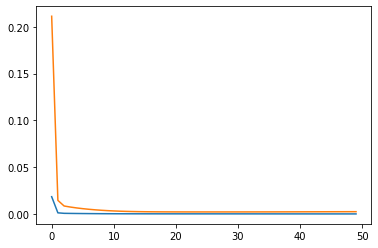

In [7]:
## attempt to plot losses over time
plt.plot(losses[1:,0], losses[1:,1:])

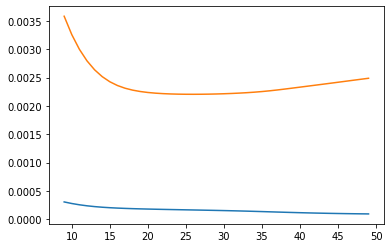

In [8]:
## attempt to plot losses over time to sho where the model started overfitting on the data
plt.plot(losses[10:,0], losses[10:,1:])

Therefore, it can be seen that the network learns some of the relationships in the dataset, and is able to overfit it after a while.

In [9]:
%matplotlib inline 
#f = plt.figure()


#plt.imshow(concat_input[:,:,0])
def plot_grid_2d(concat_input, concat_output):
    
    f, axarr = plt.subplots(2,5, figsize = (15,6)) 
    
    axarr[0,0].imshow(np.abs(concat_input[:,:,0]))
    axarr[0,0].set(title='smoothed map')

    axarr[0,1].imshow(np.abs(concat_input[:,:,1]))
    axarr[0,1].set(title='X displacement B.C.')

    axarr[0,2].imshow(np.abs(concat_input[:,:,2]))
    axarr[0,2].set(title='Y displacement B.C.')

    axarr[0,3].imshow(np.abs(concat_input[:,:,3]))
    axarr[0,3].set(title='Z displacement  B.C')

    axarr[0,4].imshow(np.abs(concat_input[:,:,4]))
    axarr[0,4].set(title='X force B.C.')

    axarr[1,0].imshow(np.abs(concat_input[:,:,5]))
    axarr[1,0].set(title='Y force B.C.')

    axarr[1,1].imshow(np.abs(concat_input[:,:,6]))
    axarr[1,1].set(title='Z force B.C.')

    axarr[1,2].imshow(np.abs(concat_output[:,:,1]))
    axarr[1,2].set(title='X displacement result')

    axarr[1,3].imshow(np.abs(concat_output[:,:,2]))
    axarr[1,3].set(title='Y displacement result')

    axarr[1,4].imshow(np.abs(concat_output[:,:,3]))
    axarr[1,4].set(title='Z displacement result')

    plt.show()

(32, 32, 7) (32, 32, 4)


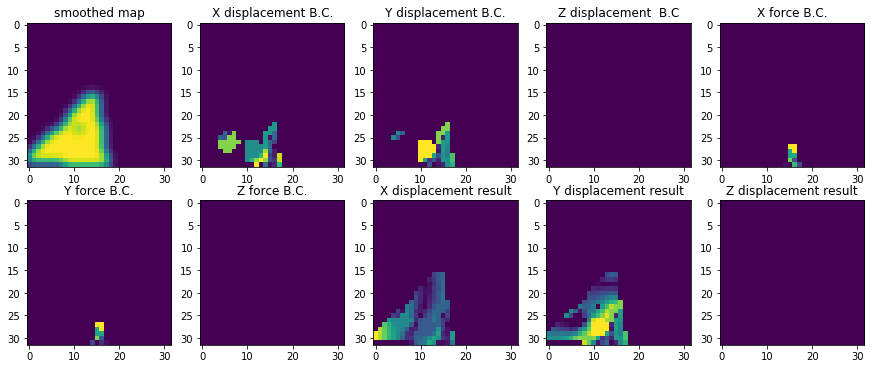

In [24]:
#plot ground truth
sample = 96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
sample_target = np.moveaxis(dataset[1][sample,:,:,:].numpy(), 0, 2)
print(sample_bc.shape, sample_target.shape)
plot_grid_2d(sample_bc, sample_target)

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


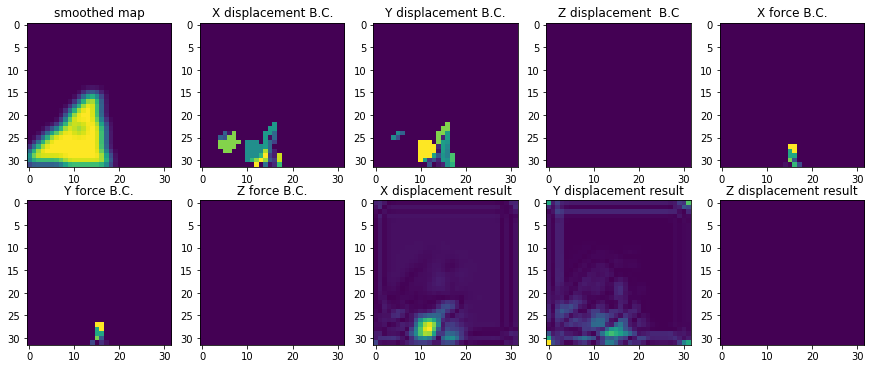

In [41]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

So one of the conclusions is that the convolutional network was  able to succesfully learn a model that can be applied to a space to generate a result  that correlates to the target. Even with a very small number of samples, the network was able to learn some basic principles about the geometry of the sample and of the relationships between boundary conditions and targets

In [53]:
## get loss of the results
with torch.no_grad():
    print(dataset[1][sample, 1:4, :, :].unsqueeze(0).shape)
    print(net.forward(dataset[0][sample:sample+1,:,:,:]).shape)
    loss_1_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), net.forward(dataset[0][sample:sample+1,:,:,:]))
    print(f'{loss_1_it: .9f}')

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
 0.000156545


In [32]:
## create a generator to evaluate how loss progresses with multiple applications of the network
def convolute_iteration(conditions, netwrk, repeat = True):
    with torch.no_grad():
        pred = netwrk(conditions) #torch.Size([1, 3, 32, 32])
        new_condition = conditions.clone()
        new_condition[:, 1:4, :, :] = pred
        i=0
        while repeat:
            i +=1
            print(i)
            pred = netwrk(new_condition)
            new_condition = conditions.clone()
            new_condition[:, 1:4, :, :] = pred
            
            yield pred

In [118]:
## create iterator intance for loss plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)
loss_iterator = []

95
 0.116603315


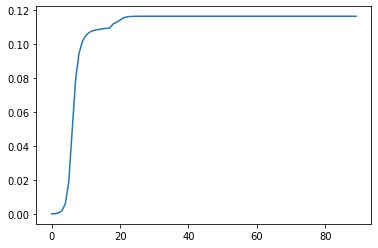

In [213]:
with torch.no_grad():
    
    loss_2_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), next(predicts))
    loss_iterator.append(loss_2_it)
    print(f'{loss_2_it: .9f}')
    plt.plot(loss_iterator)

What has been shown with this is that subsequent applications of this model don't increase its accuracy, however it does converge to a certain value. The fact that there is convergence is grounds for exploring whether this convergence can be used as a feature of the model itself.

In [215]:
## create iterator intance for prediction plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)


2
torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


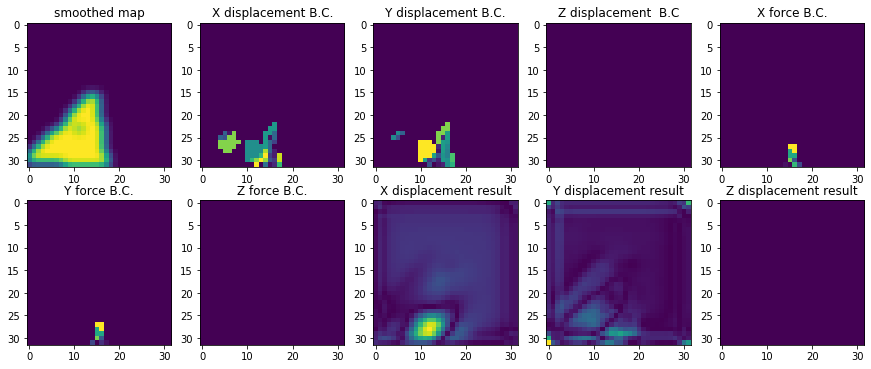

In [217]:
sample_prediction = next(predicts)
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

Now I want to explore a lot of things and their impact on the model's predictions:

- leaning rates
- different conv deconv architectures
- pre-trained models (if models trained on images help with accuracy in this case, then it is possible to use models trained in other types of object for the 3d version)
- attention
- different losses
- increase amount of model forward feeds before doing gradient descent to try to get the model to converge closer to the target value if applied several times
- Other activation strategies

## ENCODER DECODER

In [234]:
## First, see the result of a conv-deconv architecture with exactly the same parameters but that condenses
## the inputs into a feature array first
## define the neural network's general shape

class Encode_decode_Net(nn.Module):
    def __init__(self):
        super(Encode_decode_Net, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 2,stride = 2, padding = 0)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 2, stride = 2, padding = 0)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        ## Pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        
    def forward(self, boundary_conditions):
        print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.maxpool(x)
        x = self.hardtanh(x)
        print(x.shape)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.hardtanh(x)
        print(x.shape)
        x = self.deconv1(x)
        x = self.hardtanh(x)
        print(x.shape)
        x = self.deconv2(x)
        x = self.hardtanh(x)
        print(x.shape)
        x = self.deconv3(x)
        x = self.hardtanh(x)
        print(x.shape)
        x = self.deconv4(x)
        x = self.hardtanh(x)
        print(x.shape)
        return x
    
net = Encode_decode_Net().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:])

torch.Size([1, 7, 32, 32])
torch.Size([1, 14, 16, 16])
torch.Size([1, 16, 8, 8])
torch.Size([1, 14, 8, 8])
torch.Size([1, 10, 16, 16])
torch.Size([1, 7, 32, 32])
torch.Size([1, 3, 32, 32])


tensor([[[[-0.1433, -0.1737, -0.1077,  ..., -0.1781, -0.1072, -0.0982],
          [-0.1561, -0.1052, -0.1407,  ..., -0.1069, -0.1431, -0.0614],
          [-0.1240, -0.1427, -0.0950,  ..., -0.1395, -0.0978, -0.0989],
          ...,
          [-0.1558, -0.1111, -0.1368,  ..., -0.1061, -0.1406, -0.0640],
          [-0.1251, -0.1452, -0.0929,  ..., -0.1421, -0.0965, -0.0979],
          [-0.1653, -0.1376, -0.1696,  ..., -0.1352, -0.1715, -0.1359]],

         [[ 0.1218,  0.1640,  0.1308,  ...,  0.1653,  0.1280,  0.1133],
          [ 0.1018,  0.1145,  0.1482,  ...,  0.1109,  0.1520,  0.1276],
          [ 0.0675,  0.1379,  0.1169,  ...,  0.1364,  0.1122,  0.1219],
          ...,
          [ 0.1042,  0.1141,  0.1453,  ...,  0.1109,  0.1473,  0.1306],
          [ 0.0664,  0.1382,  0.1165,  ...,  0.1338,  0.1185,  0.1216],
          [ 0.0755,  0.0975,  0.1310,  ...,  0.0963,  0.1304,  0.1276]],

         [[ 0.0244, -0.1179, -0.0427,  ..., -0.1200, -0.0438, -0.1497],
          [-0.0126, -0.1435, -